# Analysis

In [1]:
#| default_exp analysis

In [15]:
#| export
import os, torch, torch.multiprocessing as mp, pickle, numpy as np, re, scipy.sparse as sp, json
from typing import Optional, Dict, List, Tuple, Union
from torch.utils.data import Dataset
from scipy import sparse
from termcolor import colored, COLORS
import matplotlib.pyplot as plt

from plum import dispatch

from xcai.basics import *
from xcai.data import *
from xcai.sdata import *
from xcai.core import store_attr
from xcai.learner import XCPredictionOutput

import xclib.utils.sparse as xc_sparse
import xclib.evaluation.xc_metrics as xc_metrics
import xclib.data.data_utils as du 

from IPython.display import HTML

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
#| hide
from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

## Setup

In [5]:
from xcai.main import *

In [6]:
data_dir = '/Users/suchith720/Projects/data/'

config_key = "data_meta"
config_dir = "/Users/suchith720/Projects/mogicX/configs"
config_file = f"{config_dir}/39_oak-for-msmarco-with-hard-negatives_test.json"

In [7]:
pkl_dir = f"{data_dir}/processed/mogicX"
pkl_file = get_pkl_file(pkl_dir, 'wikiseealsotitles_data-oak-for-msmarco-with-hard-negatives-test_distilbert-base-uncased', 
                        True, False, False)

In [8]:
pkl_file

'/Users/suchith720/Projects/data//processed/mogicX/wikiseealsotitles_data-oak-for-msmarco-with-hard-negatives-test_distilbert-base-uncased_sxc.joblib'

In [9]:
%%time
block = build_block(pkl_file, config_file, True, config_key=config_key, only_test=False, main_oversample=True, 
                    meta_oversample={"cat_meta":False, "lnk_meta":True}, n_slbl_samples=5, 
                    n_sdata_meta_samples={"cat_meta":2, "lnk_meta":4}, do_build=True, 
                    train_meta_topk={"lnk_meta":10}, test_meta_topk={"lnk_meta":10}, return_scores=True)


/Users/suchith720/Projects/pyxclib/xclib/data/data_utils.py:263: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


CPU times: user 4min 44s, sys: 12.8 s, total: 4min 57s
Wall time: 3min 51s


In [10]:
block.test.dset.__getitems__([10, 20]).keys()

dict_keys(['data_idx', 'data_identifier', 'data_input_text', 'data_input_ids', 'data_attention_mask', 'plbl2data_idx', 'plbl2data_data2ptr', 'lbl2data_idx', 'lbl2data_scores', 'lbl2data_data2ptr', 'lbl2data_identifier', 'lbl2data_input_text', 'lbl2data_input_ids', 'lbl2data_attention_mask', 'pcat2data_idx', 'pcat2data_data2ptr', 'cat2data_idx', 'cat2data_scores', 'cat2data_data2ptr', 'cat2data_identifier', 'cat2data_input_text', 'cat2data_input_ids', 'cat2data_attention_mask', 'pcat2lbl_idx', 'pcat2lbl_lbl2ptr', 'cat2lbl_idx', 'cat2lbl_scores', 'cat2lbl_lbl2ptr', 'cat2lbl_identifier', 'cat2lbl_input_text', 'cat2lbl_input_ids', 'cat2lbl_attention_mask', 'cat2lbl_data2ptr', 'pcat2lbl_data2ptr'])

## Metric

In [4]:
#| export
def pointwise_eval(pred_lbl:sparse.csr_matrix, data_lbl:sparse.csr_matrix, data_lbl_filterer:Optional[np.ndarray]=None,
                   topk:Optional[int]=5, metric:Optional[str]='P', return_type:Optional[str]='M'):
    
    if data_lbl_filterer is not None:
        pred_lbl = Filterer.apply(pred_lbl, data_lbl_filterer)
        data_lbl = Filterer.apply(data_lbl, data_lbl_filterer)
        
    pred_lbl = xc_sparse.retain_topk(pred_lbl, k=topk)
        
    scores = pred_lbl.multiply(data_lbl)
    scores.data[:] = 1
        
    if metric == 'P':
        scores = scores.multiply(1/(topk * data_lbl.shape[0]))
    elif metric == 'R':
        d = data_lbl.getnnz(axis=1) * data_lbl.shape[0]
        scores = scores.multiply(1/d.reshape(-1,1))
    elif metric == 'FN':
        scores = data_lbl - scores
        scores.eliminate_zeros()
        lbl_cnt = data_lbl.getnnz(axis=0)
        scores = scores.multiply(1/(lbl_cnt * data_lbl.shape[1]))

    if return_type == 'M': return scores
    elif return_type == 'L': return np.ravel(scores.sum(axis=0))
    else: return np.ravel(scores.sum(axis=1))
    

## Decile plot

In [5]:
#| export
def equal_volume_split(data_lbl:sparse.csr_matrix, n_split:int):
    lbl_cnt = data_lbl.getnnz(axis=0)
    lbl_idx = np.argsort(-lbl_cnt)
    thresh = lbl_cnt.sum()/n_split
    
    splits,split,cnt = [],[],0
    for idx in lbl_idx:
        cnt += lbl_cnt[idx]
        split.append(idx)

        if cnt > thresh: 
            splits.append(split)
            split,cnt = [],0

    if len(split): splits.append(split)
    
    if len(splits) != n_split: raise ValueError(f'Number of splits created less than {n_split}.')
    splits.append(lbl_idx.tolist())
    
    lbl_cnt = lbl_cnt.astype(np.float32)
    lbl_cnt[lbl_cnt == 0] = np.nan
    info = [f'{i+1}\n{len(split)//1000}K\n{np.nanmean(lbl_cnt[split]):.2f}' for i,split in enumerate(splits)]
    return splits,info
    

In [6]:
#| export
def get_decile_stats(pred_lbl:sparse.csr_matrix, data_lbl:sparse.csr_matrix, data_lbl_filterer:np.ndarray, 
                     n_split:Optional[int]=5, topk:Optional[int]=5, metric:Optional[str]='P'):
    
    evals = pointwise_eval(pred_lbl, data_lbl, data_lbl_filterer, topk=topk, metric=metric)
    splits, info = equal_volume_split(data_lbl, n_split)
    values = [evals[:, split].sum()*100 for split in splits]
    return info, values


In [7]:
#| export
def barplot(scores:Dict, title:Optional[str]='', ylabel:Optional[str]='', figsize:Optional[Tuple]=(15,10), fname:Optional[str]=None):
    n_proc,n_split = len(scores),len(list(scores.values())[0][0])
    idx, width = np.arange(n_split), 0.8/n_proc
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid()

    shift = 0
    for proc,(info,values) in scores.items(): 
        x = idx + shift
        ax.bar(x=x, height=values, width=width, alpha=1, label=proc)
        shift += width

    shift = (n_proc//2)*width if n_proc%2 else width/2 + ((n_proc-1)//2)*width

    ax.set_title(title, fontsize=22)

    ax.set_xlabel('Quantiles \n (Increasing Freq.)', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

    ax.set_xticks(idx + shift, info, fontsize=14)
    for o in ax.get_yticklabels(): o.set_fontsize(14)

    ax.legend(fontsize=14)
    
    if fname is not None: plt.savefig(fname)
    

In [8]:
#| export
def decile_plot(preds:Dict, data_lbl:sparse.csr_matrix, data_lbl_filterer:Optional[np.array]=None, 
                n_split:Optional[int]=5, topk:Optional[int]=5, metric:Optional[str]='P', figsize:Optional[Tuple]=(15,10), 
                title:Optional[str]='', fname:Optional[str]=None):
    scores = {}

    for method, pred in preds.items():
        info, values = get_decile_stats(pred, data_lbl, data_lbl_filterer, n_split=5, topk=5, metric='P')
        scores[method] = (info,values)
    
    barplot(scores, title, f'{metric}@{topk}', figsize, fname)
    

### Example

In [ ]:
pred_dir = '/home/scai/phd/aiz218323/scratch/momos_predictions/'

fnames = {
    'MOMOs (OAK)': f'{pred_dir}/momos.npz',
    'OAK': f'{pred_dir}/oak.npz',
    'NGAME': f'{pred_dir}/ngame.npz'
}

preds = {k: sparse.load_npz(v) for k,v in fnames.items()}

In [ ]:
preds

{'MOMOs (OAK)': <177515x312330 sparse matrix of type '<class 'numpy.float32'>'
 	with 35503000 stored elements in Compressed Sparse Row format>,
 'OAK': <177515x312330 sparse matrix of type '<class 'numpy.float32'>'
 	with 55431028 stored elements in Compressed Sparse Row format>,
 'NGAME': <177515x312330 sparse matrix of type '<class 'numpy.float32'>'
 	with 79245202 stored elements in Compressed Sparse Row format>}

In [ ]:
plt.style.use(['default'])

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg_2/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


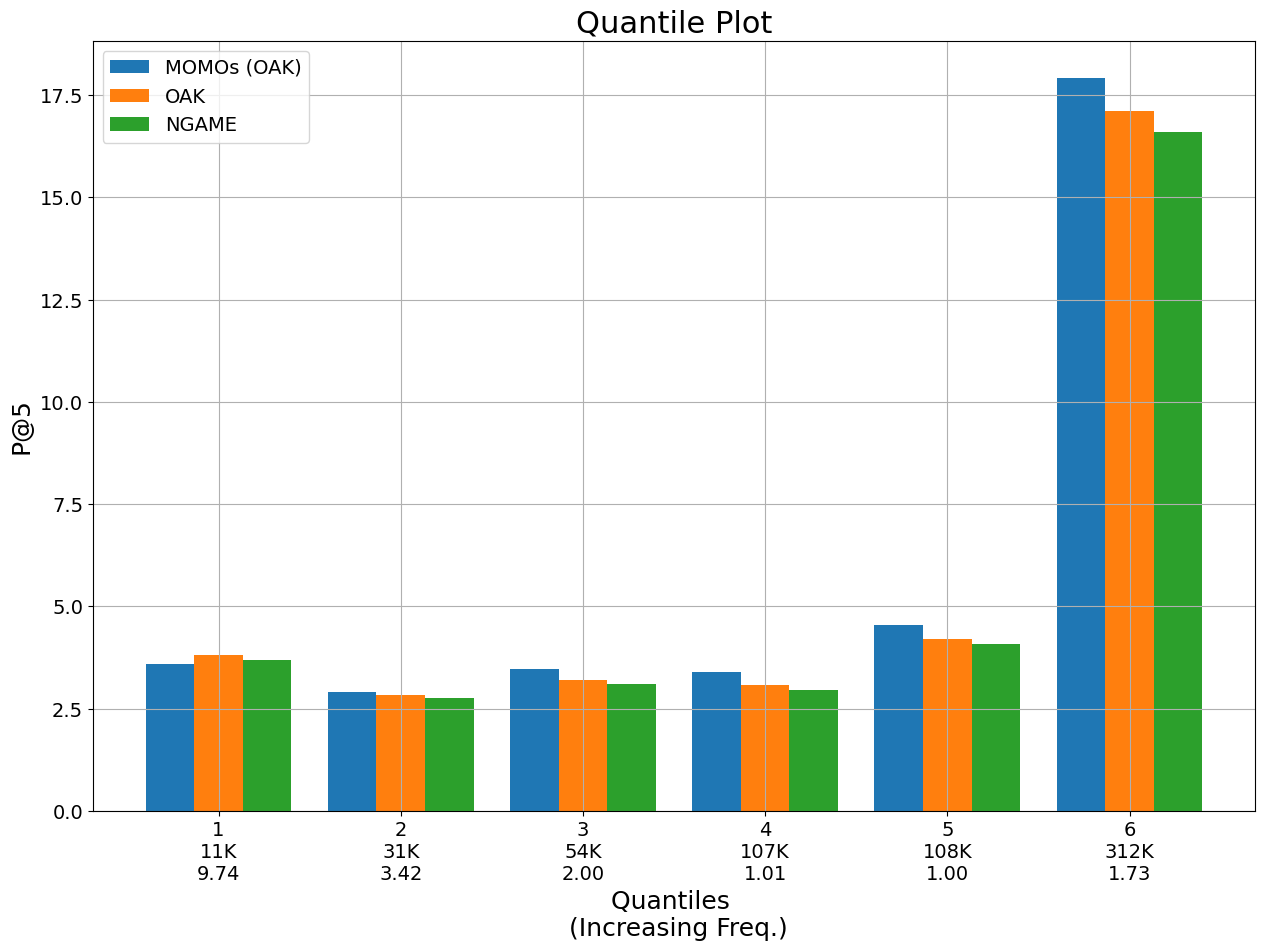

In [ ]:
decile_plot(preds, block.test.dset.data.data_lbl, block.test.dset.data.data_lbl_filterer, title='Quantile Plot', topk=5, 
            fname=f'{pred_dir}/quantile_plot.png')

## Dataset

### Load predictions

In [5]:
#| export
def get_pred_dset(pred:sp.csr_matrix, dset:Union[XCDataset,SXCDataset]):
    kwargs = {k: getattr(dset.data, k) for k in [o for o in vars(dset.data).keys() if not o.startswith('__')]}
    kwargs['data_lbl'] = pred
    data = type(dset.data)(**kwargs)
    return type(dset)(data, **dset.meta)
    

In [19]:
#| export
def get_lbl_pred_dset(pred:sp.csr_matrix, dset:Union[XCDataset,SXCDataset]):
    kwargs = {k: getattr(dset.data, k) for k in [o for o in vars(dset.data).keys() if not o.startswith('__')]}
    data = type(dset.data)(**kwargs)
    
    kwargs = {'prefix':'pred', 'data_meta': pred, 'meta_info': dset.data.lbl_info, 'return_scores': True}
    return type(dset)(data, **{'pred_meta': SMetaXCDataset(**kwargs) if isinstance(dset, SXCDataset) else MetaXCDataset(**kwargs)})
    

In [7]:
#| export
def get_pred_meta_dset(data_pred:sp.csr_matrix, dset:Union[XCDataset,SXCDataset], meta_name:str, 
                       meta_prefix:Optional[str]='lnk'):
    kwargs = {k: getattr(dset.meta[meta_name], k) for k in [o for o in vars(dset.meta[meta_name]).keys() if not o.startswith('__')]}
    kwargs['prefix'] = meta_prefix
    kwargs['data_meta'] = data_pred
    meta = type(dset.meta[meta_name])(**kwargs)
    return type(dset)(dset.data, **dset.meta, **{f'{meta_prefix}_meta': meta})
    

In [8]:
#| export
@dispatch
def get_pred_sparse(out:XCPredictionOutput, n_lbl:int):
    pred_ptr = torch.concat([torch.zeros((1,), dtype=torch.long), out.pred_ptr.cumsum(dim=0)])
    return sparse.csr_matrix((out.pred_score, out.pred_idx, pred_ptr), shape=(len(out.pred_ptr), n_lbl))

@dispatch
def get_pred_sparse(fname:str, n_lbl:int):
    with open(fname, 'rb') as f: out = pickle.load(f)
    pred_ptr = torch.concat([torch.zeros((1,), dtype=torch.long), out.pred_ptr.cumsum(dim=0)])
    return sparse.csr_matrix((out.pred_score, out.pred_idx, pred_ptr), shape=(len(out.pred_ptr), n_lbl))

@dispatch
def load_pred_sparse(fname:str):
    o = np.load(fname)
    return sparse.csr_matrix((o['data'], o['indices'], o['indptr']), dtype=float, shape=o['shape'])

def get_output(fname:str, n_lbl:int, pred_type:Optional[str]='repr_output'):
    with open(pname, 'rb') as f: out = pickle.load(f)
    preds,targ = get_output_sparse(**getattr(out,pred_type), n_lbl=n_lbl)
    return preds, targ
    

In [9]:
#| export
def load_prediction_and_block(pkl_file:str, config_file:str, config_key:str, pred_file:str, use_sxc_sampler=True):
    block = build_block(pkl_file, config_file, use_sxc_sampler, config_key)
    pred = sparse.load_npz(pred_file)
    return pred, block
    

In [12]:
#| export
class PredictionBlock:

    def __init__(self, dset, pred, num_preds=10, pattern=r'.*_text'):
        self.dset, self.pred = dset, pred
        self.num_preds, self.pattern = num_preds, pattern
        if isinstance( self.dset, SXCDataset): self.dset = XCDataset._initialize(self.dset)

    @property
    def n_data(self): return self.dset.n_data
        
    @property
    def n_lbl(self): return self.dset.n_lbl

    def __getitem__(self, idx):
        prefix = 'pred2data'
        x = self.dset[idx]
        sort_idx = np.argsort(self.pred[idx].data)[:-self.num_preds-1:-1]
        x[f'{prefix}_idx'] = self.pred[idx].indices[sort_idx]
        if self.dset.data.lbl_info is not None:
            x.update({f'{prefix}_{k}':[v[i] for i in x[f'{prefix}_idx']] for k,v in self.dset.data.lbl_info.items() if k in self.dset.data.lbl_info_keys})
        return {k:v for k,v in x.items() if re.match(self.pattern, k)}
        

### `TextDataset`

In [13]:
#| export
class TextDataset:
    
    def __init__(
        self, 
        dset, 
        pattern:Optional[str]='.*_text$',
        combine_info:Optional[bool]=False,
        sort_by:Optional[str]=None,
    ):
        store_attr('dset,pattern,combine_info,sort_by')
        if type(self.dset) is not XCDataset: self.dset = XCDataset._initialize(dset)
        self.colors = np.random.choice(list(COLORS), len(COLORS), replace=False)
    
    def __getitem__(self, idx):
        o = self.dset[idx]
        return {k:v for k,v in o.items() if re.match(self.pattern, k)}

    @property
    def n_data(self): return self.dset.n_data
        
    @property
    def n_lbl(self): return self.dset.n_lbl

    def show(self, idxs:Optional[List]=None, k=10):
        if idxs is None: 
            idxs = np.random.permutation(self.dset.n_data)[:k]
        for idx in idxs:
            for i,(k,v) in enumerate(self[idx].items()):
                key = colored(k, self.colors[i % len(self.colors)], attrs=["reverse", "blink"])
                value = colored(f': {v}', self.colors[i % len(self.colors)])
                print(key, value)
            print()

    def combine_by_prefix(self, item:Dict):
        combined_item = dict()
        for k,v in item.items():
            p,q = k.split('_', maxsplit=1)
            x = combined_item.setdefault(p, {}); x[q] = v
            
        if self.sort_by is not None:
            for n,x in combined_item.items():
                if self.sort_by in x and n.count('2') == 1:
                    idx = np.argsort(x[self.sort_by])
                    for k,v in x.items(): x[k] = [v[i] for i in idx]
                        
        return {f'{k}_({"|".join(v.keys())})' if len(v) > 1 else f'{k}_{list(v.keys())[0]}':[o for o in zip(*v.values())] if len(v) > 1 else list(v.values())[0] for k,v in combined_item.items()}
        
    def dump_txt(self, fname:str, idxs:List):
        with open(fname, 'w') as file:
            for idx in idxs:
                item = self.combine_by_prefix(self[idx]) if self.combine_info else self[idx]
                for i,(k,v) in enumerate(item.items()):
                    file.write(f'{i+1}. {k}: {v}\n')
                file.write('\n============================================\n\n')
            
    def dump_csv(self, fname:str, idxs:List):
        df = pd.DataFrame([self[idx] for idx in idxs])
        df.to_csv(fname, index=False)

    def dump_json(self, fname:str, idxs:List):
        items = [self.combine_by_prefix(self[idx]) if self.combine_info else self[idx] for idx in idxs]
        with open(fname, 'w') as file:
            json.dump(items, file, indent=4)

    def dump(self, fname, idxs):
        if fname.endswith('.txt'): 
            self.dump_txt(fname, idxs)
        elif fname.endswith('.csv'): 
            self.dump_csv(fname, idxs)
        elif fname.endswith('.json'): 
            self.dump_json(fname, idxs)
        else: 
            raise ValueError(f'Invalid file extension: {fname}')
            

#### Examples

In [43]:
dset = TextDataset(block.test.dset, combine_info=True, pattern=r'.*(_text|_scores)$', sort_by='scores')

In [44]:
dset.dump('test.txt', [10, 20, 30, 40])

### `CompareDataset`

In [ ]:
#| export
class CompareDataset:

    def __init__(self, dset1, dset2, dset1_prefix='1.', dset2_prefix='2.', pattern=r'.*_text'):
        self.dset1, self.dset2 = dset1, dset2
        self.dset1_prefix, self.dset2_prefix, self.pattern = dset1_prefix, dset2_prefix, pattern
        
        colors = list(COLORS.keys())
        self.colors = [colors[i] for i in np.random.permutation(len(colors))]

    def show(self, idxs=None, k=10):
        assert self.dset1.n_data == self.dset2.n_data, f'Different number of datapoints, dset1({self.dset1.n_data}) and dset2({self.dset2.n_data})'
        if idxs is None: idxs = np.random.permutation(self.dset1.n_data)[:k]

        for idx in idxs:
            items1, items2 = self.dset1[idx], self.dset2[idx]
            ctr = 0
            for k in items1.keys():
                if re.match(self.pattern, k):
                    color = self.colors[ctr % len(self.colors)]
                    
                    key = colored(f"{self.dset1_prefix} {k}", color, attrs=["reverse", "blink"])
                    value = colored(f': {items1[k]}', color)
                    print(key, value)
        
                    key = colored(f"{self.dset2_prefix} {k}", color, attrs=["reverse", "blink"])
                    value = colored(f': {items2[k]}', color)
                    print(key, value)

                    ctr += 1
            print()

    def dump_txt(self, fname, idxs=None, k=10):
        assert self.dset1.n_data == self.dset2.n_data, f'Different number of datapoints, dset1({self.dset1.n_data}) and dset2({self.dset2.n_data})'
        if idxs is None: idxs = np.random.permutation(self.dset1.n_data)[:k]
            
        with open(fname, 'w') as file:
            for idx in idxs:
                items1, items2 = self.dset1[idx], self.dset2[idx]
                for k in items1.keys():
                    if re.match(self.pattern, k):
                        file.write(f"{self.dset1_prefix} {k}: {items1[k]}\n")
                        file.write(f"{self.dset2_prefix} {k}: {items2[k]}\n")
                file.write('\n')
            

### `Indices`

In [ ]:
#| export
class Indices:

    def __init__(self, topk=10):
        self.topk = topk

    @staticmethod
    def head_data(dset, topk=10):
        return np.argsort(dset.data.data_lbl.getnnz(axis=1))[:-topk:-1]

    @staticmethod
    def tail_data(dset, topk=10):
        num = dset.data.data_lbl.getnnz(axis=1)
        idx = np.argsort(num)
        valid = (num > 0)[idx]
        return idx[valid][:topk]

    @staticmethod
    def metric(dset1, dset2, topk=10):
        prec_1 = pointwise_eval(dset1.pred, dset1.dset.data.data_lbl, dset1.dset.data.data_lbl_filterer)
        prec_2 = pointwise_eval(dset2.pred, dset2.dset.data.data_lbl, dset2.dset.data.data_lbl_filterer)
        
        scores = np.array(prec_1.sum(axis=1) - prec_2.sum(axis=1)).reshape(-1)
        idxs = np.argsort(scores)[:-topk-1:-1]
        return idxs
        